In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

connct = psycopg2.connect('dbname=WhiskyAdvocate user= postgres password = 23Tiafdtd32 host = 127.0.0.1 port=5432')

#Query the database to recover the needed data for unsupervised learning operations

#Query the database to recover the needed data for unsupervised learning operations

ds_query = ''' SELECT * FROM features_rev_prop'''

ml_df_full = pd.read_sql(ds_query, connct)

ml_df_full.head()

,whiskey_id,fruit_prop,wood_prop,spicy_prop,sweet_prop,maillard_prop,smoke_prop
0,0,0.400000,0.200000,0.400000,0.000000,0.000000,0.0
1,1,0.400000,0.000000,0.000000,0.200000,0.400000,0.0
2,2,0.166667,0.333333,0.166667,0.166667,0.166667,0.0
3,3,0.250000,0.000000,0.000000,0.750000,0.000000,0.0
4,4,0.333333,0.000000,0.000000,0.500000,0.166667,0.0


In [2]:
#connct.close()

I am choosing DBSCAN for clustering analysis because there are a lot of points that look like noise points, and a lot of the points look like noise points. Kmeans and agglomerative clustering are bad for irregular shaped clusters. 

In [3]:
#git rid of whiskey_id

ml_df = ml_df_full.drop(['whiskey_id'], axis = 1)

#check for missing values
ml_df.isnull().sum()

fruit_prop       0
wood_prop        0
spicy_prop       0
sweet_prop       0
maillard_prop    0
smoke_prop       0
dtype: int64

In [4]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5900 entries, 0 to 5899
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fruit_prop     5900 non-null   float64
 1   wood_prop      5900 non-null   float64
 2   spicy_prop     5900 non-null   float64
 3   sweet_prop     5900 non-null   float64
 4   maillard_prop  5900 non-null   float64
 5   smoke_prop     5900 non-null   float64
dtypes: float64(6)
memory usage: 276.7 KB


I am going to try implementing the DBSCAN clustering alogrythm using scikit learn. I have questions about how well it will work. If it doesn't work, I don't think other clustering algorythms are necessarily likely to work better because of the irregular appearance of some of the clusters when I run t-SNE. An idea I have for refactoring the project is to combine features that seem related - for instance sugar, sweet and honey could all go in the same features, and some of the fruit descriptors could be summed in another feature. This reduceds the dimensionality of the feature space along defensible lines, and may make it easier to spot clusters and patterns.  

In [5]:
#import some necessary things from sklearn

import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN


In [6]:
#rename the df because no scaling is needed this time

ml_scale = ml_df

In [7]:
#I used min max scaler, which should put all the features between 0 and 1. this means my epsilon (neighborhood) value for 
#DBSCAN needs to be small. I'm going to start with 0.05
#min samples should be kind of large because there are 5900 points in the set. 25 seems like a reasonable value to start. 

cls_1 = DBSCAN(eps = 0.1, min_samples = 25).fit_predict(ml_scale)

cls_1

array([-1, -1,  0, ..., -1, -1, -1], dtype=int64)

In [8]:
# my preferred t-SNE parameters were tsne15 = TSNE(random_state=42, perplexity = 40, learning_rate = 1000)
#copying over my helpful t-SNE functions for visualizing my clustering

def tsne_unpack(tsne_array, list1, list2):
    for t in tsne_array:
        list1.append(t[0])
        list2.append(t[1])

def visny_tsne(tsne_instantiation):
    
    ws_tsne_iter = tsne_instantiation.fit_transform(ml_scale)
    
    tsne_x = []
    tsne_y = []
    
    tsne_unpack(ws_tsne_iter, tsne_x, tsne_y)
    
    plt.figure(figsize = (12, 12))
    sns.scatterplot(x = tsne_x, y = tsne_y)
    plt.show()


In [10]:
#constructing a dataframe for t-SNE visualization of clustering
pref_tsne = TSNE(random_state=42, perplexity = 30, learning_rate = 1000)

db_tsne1 = pref_tsne.fit_transform(ml_scale)

pref_tsne_x = []
pref_tsne_y = []

tsne_unpack(db_tsne1, pref_tsne_x, pref_tsne_y)

vis1_dict = {'tSNE_x': pref_tsne_x, 'tSNE_y':pref_tsne_y}

vis_1 = pd.DataFrame(vis1_dict)

vis_1.head()

,tSNE_x,tSNE_y
0,45.758720,-15.304592
1,-36.757694,25.302685
2,2.562958,16.394543
3,15.950294,81.161903
4,-37.445004,33.395908


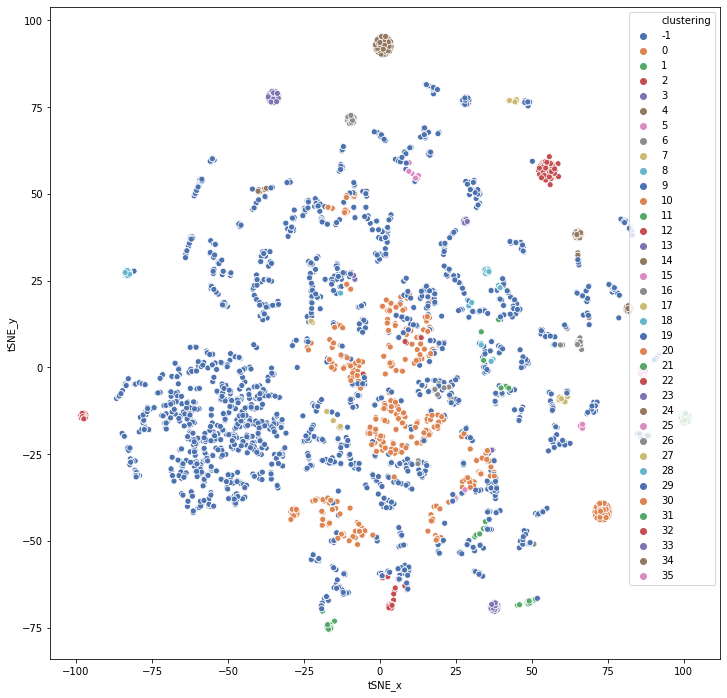

In [11]:
# adding clustering data as a new column, and visualizing

vis_1['clustering'] = cls_1

plt.figure(figsize = (12, 12))
sns.scatterplot(data = vis_1, x = 'tSNE_x', y = 'tSNE_y', hue = 'clustering', palette = 'deep')

plt.show()

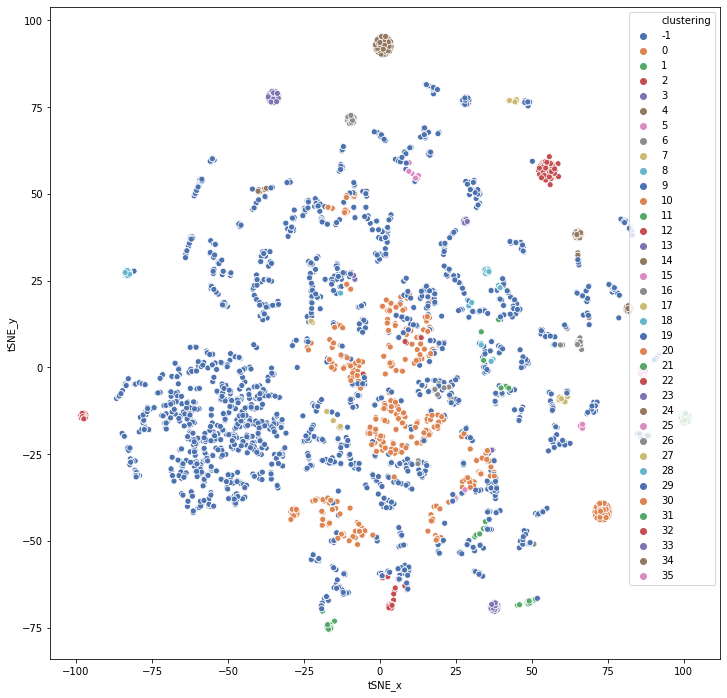

In [12]:
#elbow function is different, but still not sure I've got it right. I'm going to try a few new values for clustering (again) though, 
#based on the scales I'm seeing. 

cls_2 = DBSCAN(eps = 0.1, min_samples = 25).fit_predict(ml_scale)

#write a function to make visualizing clustering results on the t-SNE picture really easy

def cluster_vis(dbscan_array):
    vis_1['clustering'] = dbscan_array

    plt.figure(figsize = (12, 12))
    sns.scatterplot(data = vis_1, x = 'tSNE_x', y = 'tSNE_y', hue = 'clustering', palette = 'deep')

    plt.show()

cluster_vis(cls_2)
    

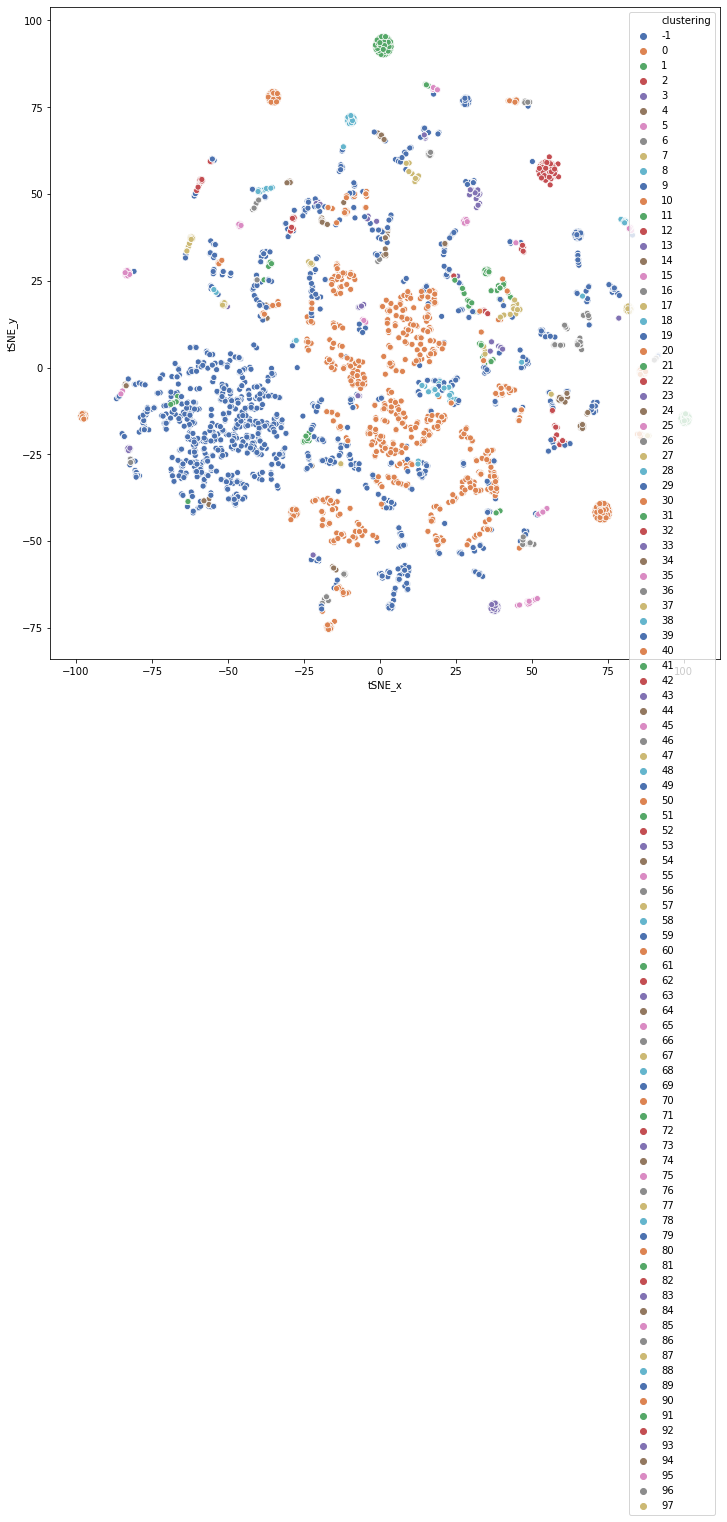

In [13]:
cls_3  = DBSCAN(eps = 0.1, min_samples = 10).fit_predict(ml_scale) 

cluster_vis(cls_3)

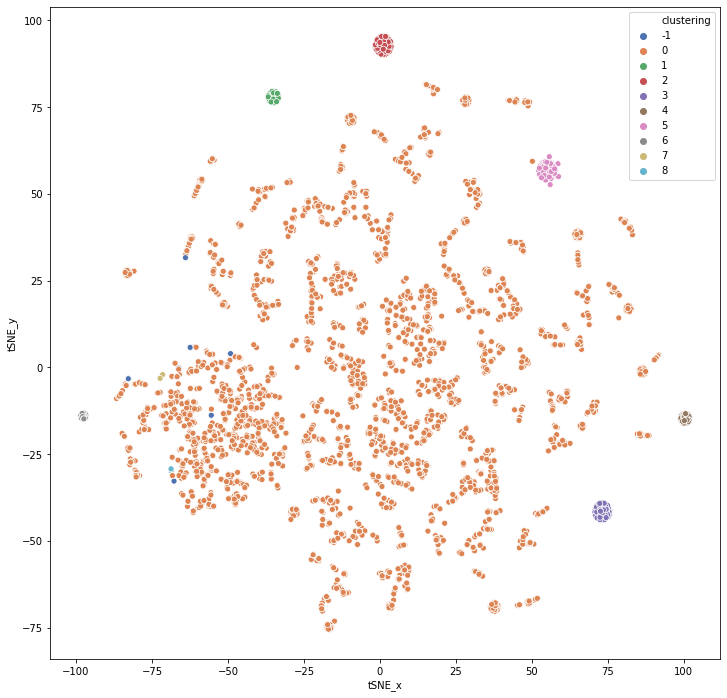

In [14]:
cls_4 = DBSCAN(eps = 0.2, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_4)

From too many to not enough.

In [15]:
#set up silhouette score
from sklearn.metrics import silhouette_score

print(f'silhouette score w noise{silhouette_score(ml_scale, cls_4)}')



silhouette score w noise0.06300538789881123


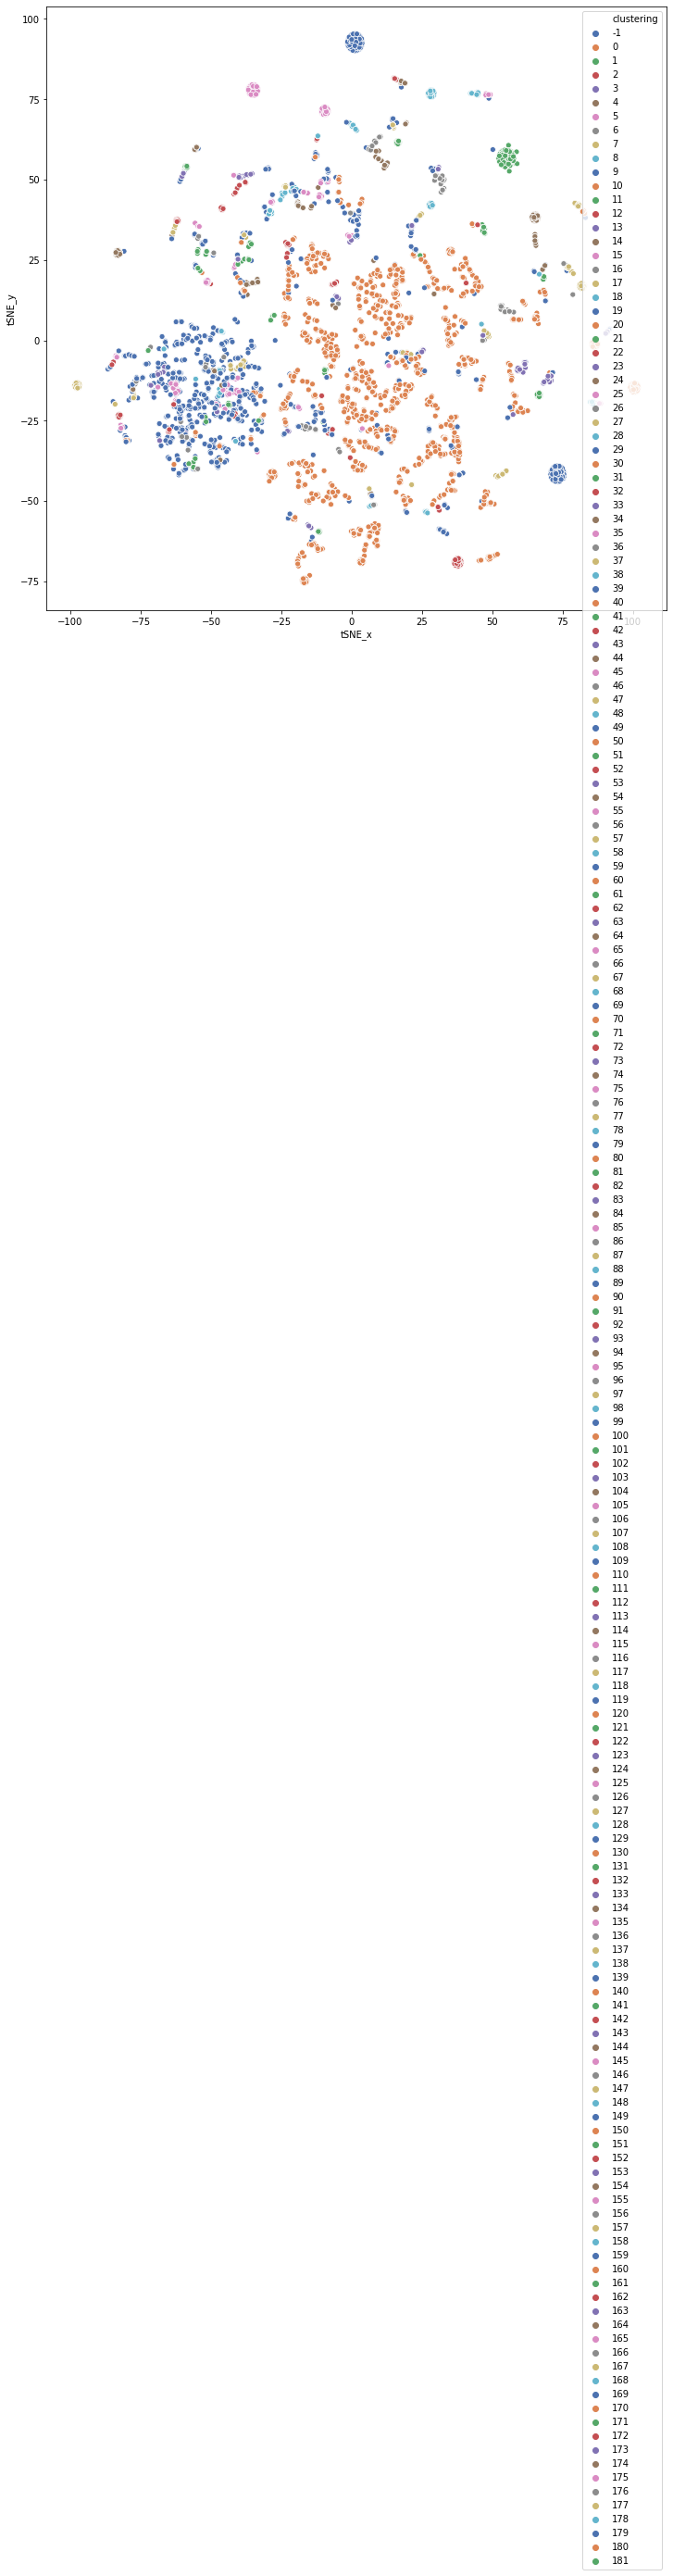

In [16]:
cls_5 = DBSCAN(eps = 0.1, min_samples = 5).fit_predict(ml_scale)

cluster_vis(cls_5)

In [17]:
print(f'silhouette score w noise{silhouette_score(ml_scale, cls_5)}')

silhouette score w noise0.04597059168104936


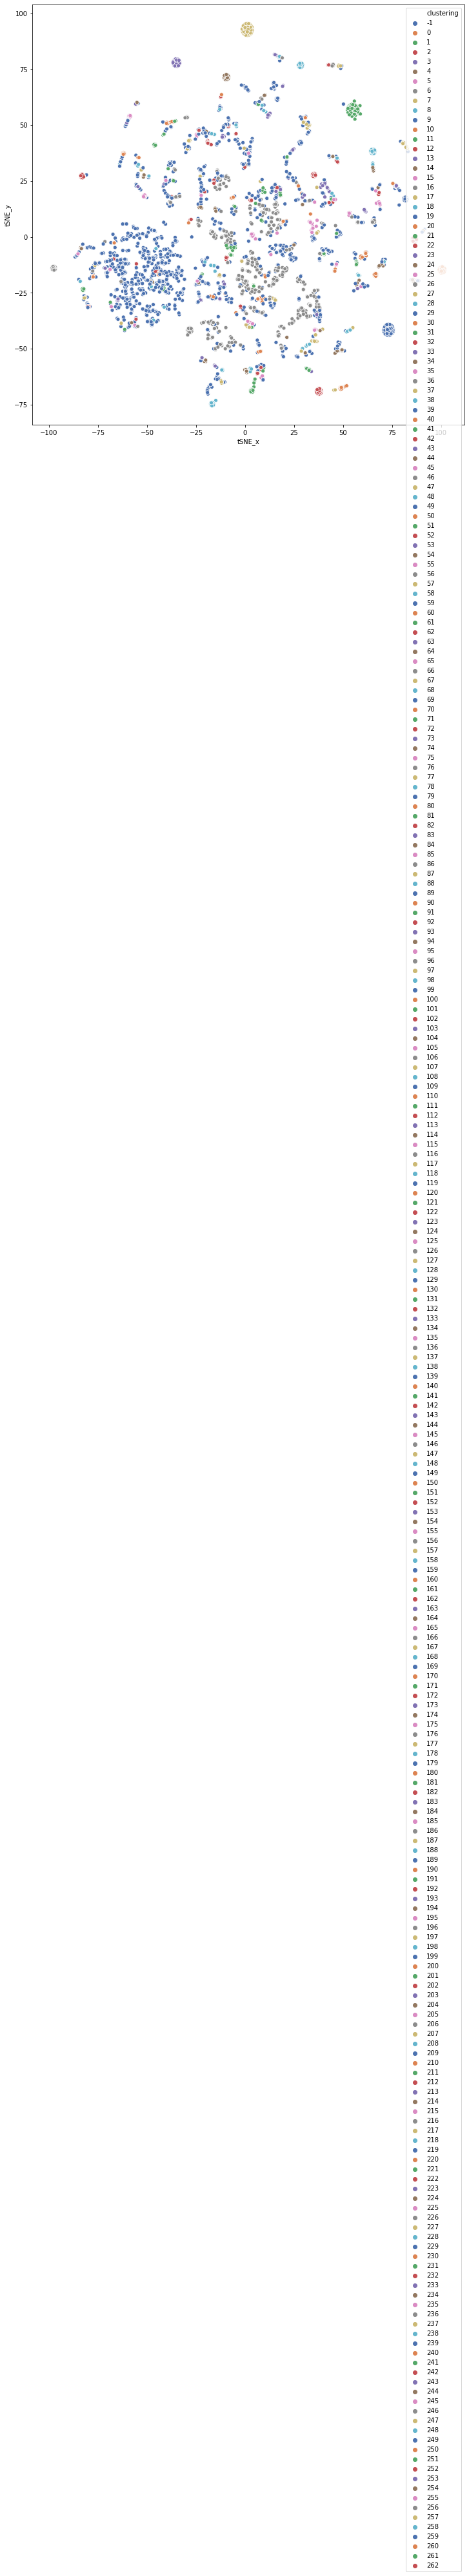

In [18]:
cls_6 = DBSCAN(eps = 0.08, min_samples = 5).fit_predict(ml_scale)

cluster_vis(cls_6)

In [21]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_6)}')

silhouette score w noise 0.2110339142986176


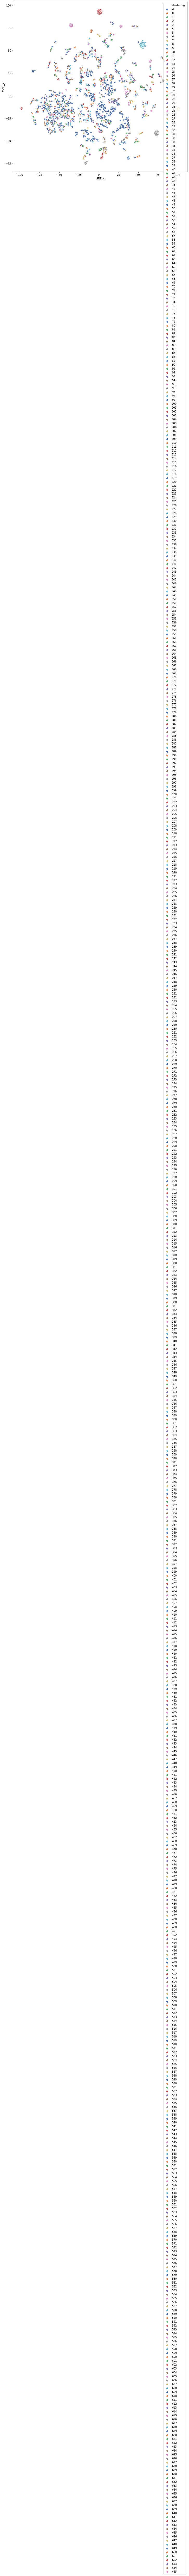

In [20]:
cls_7 = DBSCAN(eps = 0.08, min_samples = 2).fit_predict(ml_scale)

cluster_vis(cls_7)

In [22]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_7)}')

silhouette score w noise 0.4358040007449252


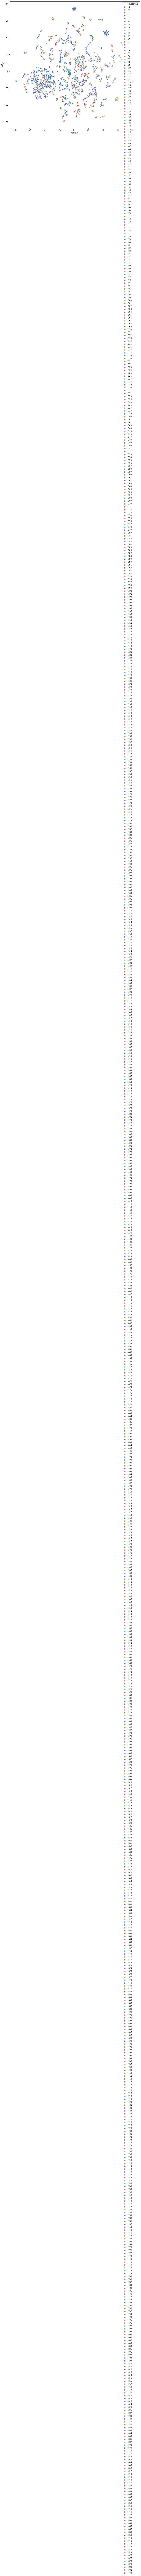

In [23]:
cls_8 = DBSCAN(eps = 0.06, min_samples = ).fit_predict(ml_scale)

cluster_vis(cls_8)

In [24]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_7)}')

silhouette score w noise 0.4358040007449252
